In [35]:
import torch
import matplotlib.pyplot as plt
from torchmetrics.classification import BinaryJaccardIndex
from torchmetrics.segmentation import DiceScore

In [36]:
device = "cpu"
dice = DiceScore(num_classes=2).to(device)
iou = BinaryJaccardIndex(threshold=0.5).to(device)

In [37]:
y_true = torch.zeros((1, 1, 5, 5), dtype=torch.float32)
y_pred = torch.zeros((1, 1, 5, 5), dtype=torch.float32)
y_true[0, 0, 1:4, 1:4] = 1.0
y_pred[0, 0, 2:5, 2:5] = 1.0

y_true = y_true.to(device)
y_pred = y_pred.to(device)

In [38]:
dice_score = dice(y_pred, y_true).item()
iou_score = iou(y_pred, y_true).item()
print(f"🎯 Dice Score: {dice_score:.4f}")
print(f"📐 IoU Score:  {iou_score:.4f}")

🎯 Dice Score: 0.4444
📐 IoU Score:  0.2857


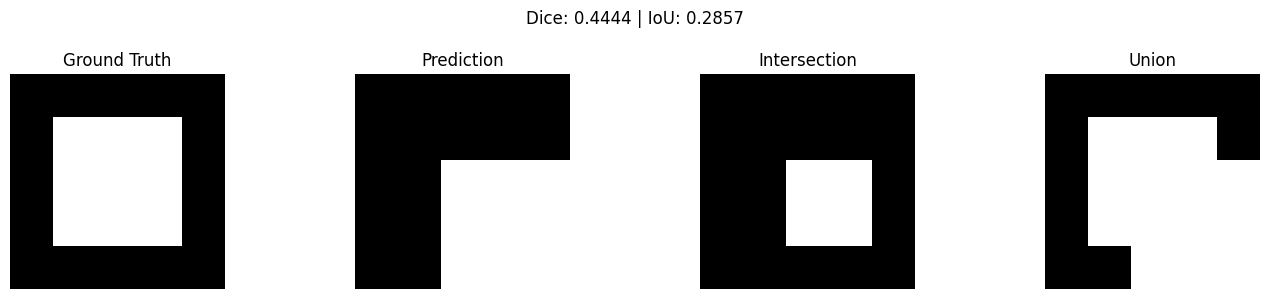

In [39]:
intersection = (y_true > 0.5) & (y_pred > 0.5)
union = (y_true > 0.5) | (y_pred > 0.5)

# --- Visualisation
fig, axes = plt.subplots(1, 4, figsize=(14, 3))

axes[0].imshow(y_true.squeeze().cpu(), cmap='gray')
axes[0].set_title("Ground Truth")

axes[1].imshow(y_pred.squeeze().cpu(), cmap='gray')
axes[1].set_title("Prediction")

axes[2].imshow(intersection.squeeze().cpu(), cmap='gray')
axes[2].set_title("Intersection")

axes[3].imshow(union.squeeze().cpu(), cmap='gray')
axes[3].set_title("Union")

for ax in axes:
    ax.axis('off')

plt.suptitle(f"Dice: {dice_score:.4f} | IoU: {iou_score:.4f}")
plt.tight_layout()
plt.show()

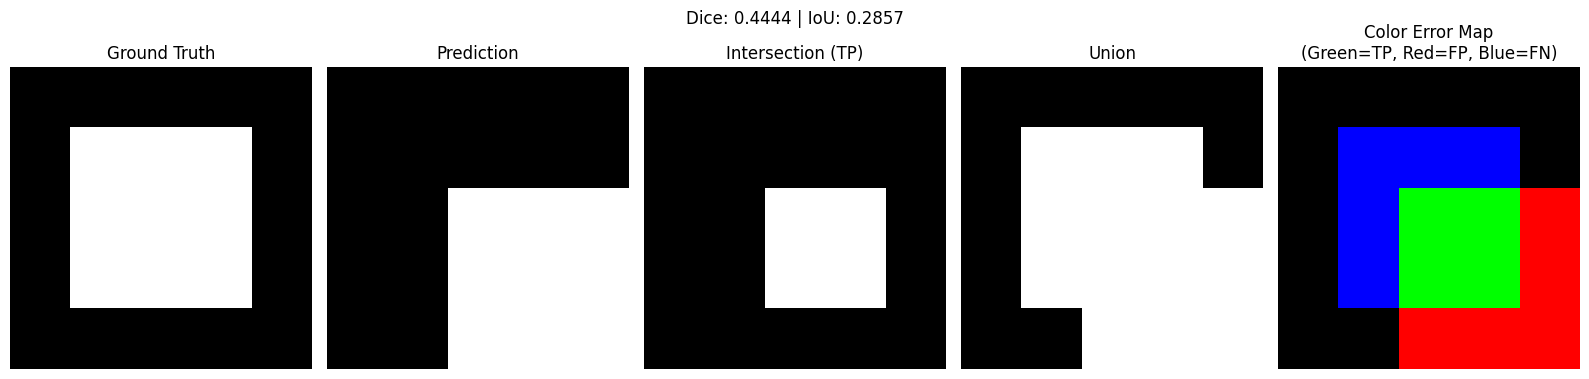

In [40]:
test_y_true = y_true.clone()
test_y_pred = y_pred.clone()

if test_y_true.ndim == 4:
    test_y_true = test_y_true.squeeze(0).squeeze(0)
    test_y_pred = test_y_pred.squeeze(0).squeeze(0)
elif y_true.ndim == 3:
    test_y_true = test_y_true.squeeze(0)
    test_y_pred = test_y_pred.squeeze(0)

# On retire le batch si présent
y_true_bin = (test_y_true > 0.5)
y_pred_bin = (test_y_pred > 0.5)

# Masques d'erreurs
tp = y_true_bin & y_pred_bin
fp = ~y_true_bin & y_pred_bin
fn = y_true_bin & ~y_pred_bin

union = y_true_bin | y_pred_bin

# Crée une image RGB de la forme (3, H, W)
height, width = y_true_bin.shape[-2], y_true_bin.shape[-1]
color_mask = torch.zeros((3, height, width), dtype=torch.float32)

# Coloration
color_mask[1][tp] = 1.0   # Vert → True Positives
color_mask[0][fp] = 1.0   # Rouge → False Positives
color_mask[2][fn] = 1.0   # Bleu → False Negatives

# --- Affichage
fig, axes = plt.subplots(1, 5, figsize=(16, 4))

axes[0].imshow(y_true_bin.cpu(), cmap='gray')
axes[0].set_title("Ground Truth")

axes[1].imshow(y_pred_bin.cpu(), cmap='gray')
axes[1].set_title("Prediction")

axes[2].imshow(tp.cpu(), cmap='gray')
axes[2].set_title("Intersection (TP)")

axes[3].imshow(union.cpu(), cmap='gray')
axes[3].set_title("Union")

axes[4].imshow(color_mask.permute(1, 2, 0).cpu())
axes[4].set_title("Color Error Map\n(Green=TP, Red=FP, Blue=FN)")

for ax in axes:
    ax.axis('off')

plt.suptitle(f"Dice: {dice_score:.4f} | IoU: {iou_score:.4f}")
plt.tight_layout()
plt.show()


In [41]:
def my_dice_score(y_true, y_pred, threshold=0.5):
    y_true_bin = (y_true > threshold).float()
    y_pred_bin = (y_pred > threshold).float()

    intersection = torch.sum(y_true_bin * y_pred_bin)
    total_pixels = torch.sum(y_true_bin) + torch.sum(y_pred_bin)
    return 2 * intersection / total_pixels if total_pixels > 0 else 1.0

# Test de la fonction my_dice_score
dice_score_custom = my_dice_score(y_true_bin, y_pred_bin).item()
print(f"Custom Dice Score: {dice_score_custom:.4f}")

dice_score_metric = DiceScore(num_classes=2).to(device)
dice_score_metric.update(y_pred, y_true)
dice_score = dice_score_metric.compute().item()
print(f"Dice Score with torchmetrics: {dice_score:.4f}")

Custom Dice Score: 0.4444
Dice Score with torchmetrics: 0.4444


In [42]:
def my_iou_score(y_true, y_pred, threshold=0.5):
    y_true_bin = (y_true > threshold).float()
    y_pred_bin = (y_pred > threshold).float()

    intersection = torch.sum(y_true_bin * y_pred_bin)
    union = torch.sum((y_true_bin + y_pred_bin) > 0).float()
    return intersection / union if union > 0 else 1.0

# Test de la fonction my_iou_score
iou_score_custom = my_iou_score(y_true_bin, y_pred_bin).item()
print(f"Custom IoU Score: {iou_score_custom:.4f}")

# Test de la fonction my_iou_score avec torchmetrics
iou_score_metric = BinaryJaccardIndex(threshold=0.5).to(device)
iou_score_metric.update(y_pred, y_true)
iou_score = iou_score_metric.compute().item()
print(f"IoU Score with torchmetrics: {iou_score:.4f}")

Custom IoU Score: 0.2857
IoU Score with torchmetrics: 0.2857


In [2]:
import os
import psutil

print(f"Core cpu : {os.cpu_count()}")
mem = psutil.virtual_memory()
total_gb = mem.total / 1e9
available_gb = mem.available / 1e9

print(f"Total RAM: {total_gb:.2f} GB")
print(f"Available RAM: {available_gb:.2f} GB")

Core cpu : 24
Total RAM: 253.34 GB
Available RAM: 208.94 GB
